In [1]:
%reload_ext autoreload
%autoreload 2
import sys
sys.path.insert(1, '../functions/')
from statistics_functions import *
import os
import numpy as np
import xarray as xr
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams.update({'font.size': 14})
import cartopy.crs as ccrs
import cartopy

In [2]:
base_path  = '/work/bk1377/a270230/'
path_ds    = base_path + 'lkf_datasets/daily_data/'
path_ice   = base_path + 'interpolated_fesom_output/'
path_out   = base_path + 'data_transfer/'

# check that both the dataset and the nc file exist
files = os.listdir(path_ice)
files.sort()
files.remove('.ipynb_checkpoints')
#files.remove('fesom_ifs')
#files

# Load the Detected and Tracked LKFs

In [3]:
[years, ice_extent, mean_ice_thickness] = np.load(path_out + 'ice_extent.npy', allow_pickle=True)

In [4]:
years = [2013, 2016, 2020, 2093, 2096, 2099]

In [5]:
# only use the value for the years selected above
ice_extent = [ice_extent[i] for i in [0,3,7,8,11,14]]

In [6]:
%%time
# load the data from the lkf_data files
# paths_all also includes the paths going through each timestep

datasets, lkfs = get_lkf_data(path_ds, years)
tracks = get_tracks(datasets)
paths, paths_all = get_paths(lkfs, tracks)

CPU times: user 33.4 s, sys: 1.55 s, total: 35 s
Wall time: 1min 14s


# Calculate Metrics

In [7]:
# lifetimes_all includes the lifetimes of LKFs that are already counted in
# previous timesteps

n_lkfs = get_n_lkfs(lkfs)
rho_lkfs = np.array(n_lkfs) / ice_extent * 10000
res_km = get_res_km(datasets)
length, av_length, total_length = get_lkf_length(lkfs, res_km)
lifetimes, mean_lifetime = get_lkf_lifetimes(paths)
lifetimes_all, _ = get_lkf_lifetimes(paths_all)

/tmp/ipykernel_3098497/3760230300.py:5: RuntimeWarning: invalid value encountered in divide
  rho_lkfs = np.array(n_lkfs) / ice_extent * 10000
/home/a/a270230/.conda/envs/lkf_tools/lib/python3.12/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/home/a/a270230/.conda/envs/lkf_tools/lib/python3.12/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)
/home/a/a270230/LKF/lkf_detection/statistics/../functions/statistics_functions.py:225: RuntimeWarning: Mean of empty slice.
  mean_lifetime_y += lifetimes_timestep.mean(),
/home/a/a270230/.conda/envs/lkf_tools/lib/python3.12/site-packages/numpy/core/_methods.py:131: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret / rcount


In [8]:
np.save(path_out + 'data_lkfs_paths.npy', np.array([years, lkfs, paths, paths_all], dtype='object'), allow_pickle=True)

In [9]:
[years, lkfs, paths, paths_all] = np.load(path_out + 'data_lkfs_paths.npy', allow_pickle=True)

# Average Over Decades

In [10]:
def av_sd(data,i=3):
    
    av = np.mean(data[:i], axis=0)
    sd = np.sqrt(np.var(data[:i], axis=0))
    
    av_90 = np.mean(data[i:], axis=0)
    sd_90 = np.sqrt(np.var(data[i:], axis=0))

    return av, sd, av_90, sd_90

In [11]:
n_lkfs_av, n_lkfs_sd, n_lkfs_90_av, n_lkfs_90_sd = av_sd(n_lkfs)
rho_lkfs_av, rho_lkfs_sd, rho_lkfs_90_av, rho_lkfs_90_sd = av_sd(rho_lkfs)

mean_length_av, mean_length_sd, mean_length_90_av, mean_length_90_sd = av_sd(av_length)
total_length_av, total_length_sd, total_length_90_av, total_length_90_sd = av_sd(total_length)

mean_lkf_lt_av, mean_lkf_lt_sd, mean_lkf_lt_90_av, mean_lkf_lt_90_sd = av_sd(mean_lifetime)

# Create LKF Dictionary

In [12]:
LKFs = dict()

for decade, i in zip(['2010s', '2090s'], [[0,1], [2,3]]):

    df = pd.DataFrame(av_sd(n_lkfs)[i[0]], columns=['number'])
    df['number sd']        = av_sd(n_lkfs)[i[1]]
    df['density']          = av_sd(rho_lkfs)[i[0]]
    df['density sd']       = av_sd(rho_lkfs)[i[1]]
    df['mean length']      = av_sd(av_length)[i[0]]
    df['mean length sd']   = av_sd(av_length)[i[1]]
    df['total length']     = av_sd(total_length)[i[0]]
    df['total length sd']  = av_sd(total_length)[i[1]]
    df['mean lifetime']    = av_sd(mean_lifetime)[i[0]]
    df['mean lifetime sd'] = av_sd(mean_lifetime)[i[1]]

    LKFs[decade] = df

for y in range(len(years)):
    df_y = pd.DataFrame(n_lkfs[y], columns=['number'])
    df_y['density']       = rho_lkfs[y]
    df_y['mean length']   = av_length[y]
    df_y['total length']  = total_length[y]
    df_y['mean lifetime'] = mean_lifetime[y]
    
    LKFs[f'y{years[y]}'] = dict(
        total = df_y,
    )
    
    for d in range(365):
        df_d = pd.DataFrame(length[y][d], columns=['length'])
        df_d['lifetime'] = lifetimes_all[y][d]
        
        LKFs[f'y{years[y]}'][f'd{d}'] = df_d

In [13]:
np.save(path_out + 'LKFs', [LKFs])

# Load LKF Dictionary

In [14]:
LKFs = np.load(path_out + 'LKFs.npy', allow_pickle=True)[0]

In [15]:
years = []
for key in LKFs.keys():
    years += key,
    
years = years[2:]

for i, year in enumerate(years):
    years[i] = int(year[1:])

# Plot one individual year

In [16]:
years

[2013, 2016, 2020, 2093, 2096, 2099]

In [17]:
year = 2013

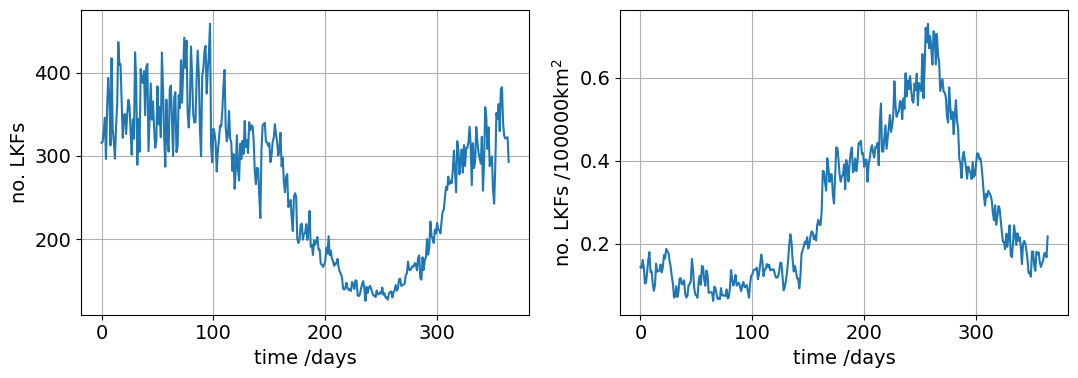

In [18]:
fig, axs = plt.subplots(1,2, figsize=(11,4))

for ax, data, ylabel in zip(
    axs, [LKFs[f'y{year}']['total']['mean length'], LKFs[f'y{year}']['total'].density], ['no. LKFs', 'no. LKFs /100000km$^2$']
):
    
    ax.plot(data)
    ax.set_ylabel(ylabel)
    ax.set_xlabel('time /days')
    ax.grid()

fig.tight_layout()

# Compare individual years

In [19]:
years

[2013, 2016, 2020, 2093, 2096, 2099]

In [20]:
year1 = 2013
year2 = 2093

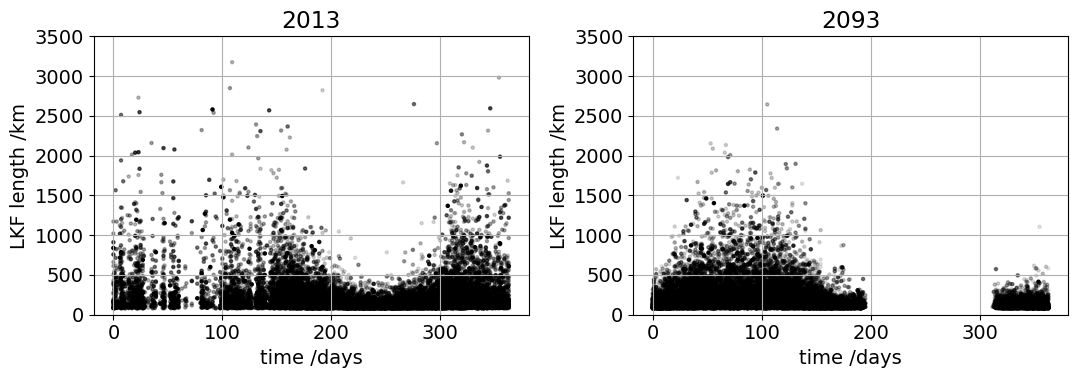

In [21]:
var = 'length'
ylabel = 'LKF length /km'
r = 364

fig, axs = plt.subplots(1,2,figsize=(11,4))

for ax, year in zip(axs, [year1, year2]):

    for d in range(r):
        values = LKFs[f'y{year}'][f'd{d}'][var]

        bins = 10
        val = np.histogram(values, bins=bins)[1]
        val = [0.5*(val[i]+val[i+1]) for i in range(len(val)-1)]
        f = np.histogram(values, bins=bins)[0]
        if np.max(f)>0:
            f = f/np.max(f)

        try:
            frequency = np.zeros(int(np.max(values)+1))
            for value in values:
                frequency[int(value)] += 1

            f_norm = 0
            if frequency.max()>0:
                f_norm = frequency/frequency.max()
        except:
            f_norm = 0
                

        ax.scatter(d * np.ones_like(values), values, s=5, c='k', alpha=f_norm)

    ax.grid()
    ax.set_ylim([0,3500])
    ax.set_ylabel(ylabel)
    ax.set_xlabel('time /days')
    ax.set_title(year)
fig.tight_layout()

# Compare 2010s with 2090s

In [22]:
def compare(var, ylabel, ylim):
    j = 151

    fig, axs = plt.subplots(1,2, figsize=(11,4))

    for ax, data, var, title in zip(
        axs, [LKFs['2010s'][var][:j], LKFs['2090s'][var][:j]], [LKFs['2010s'][var+' sd'][:j], LKFs['2090s'][var+' sd'][:j]], ['2013 - 2020', '2093 - 2100']
    ):

        ax.plot(data)
        ax.fill_between(np.arange(j), data+var, data-var, alpha=0.5)
        ax.set_ylabel(ylabel)
        ax.set_xlabel('time /days')
        ax.set_ylim([0,ylim])
        ax.set_title(title)
        ax.grid()

    fig.tight_layout()

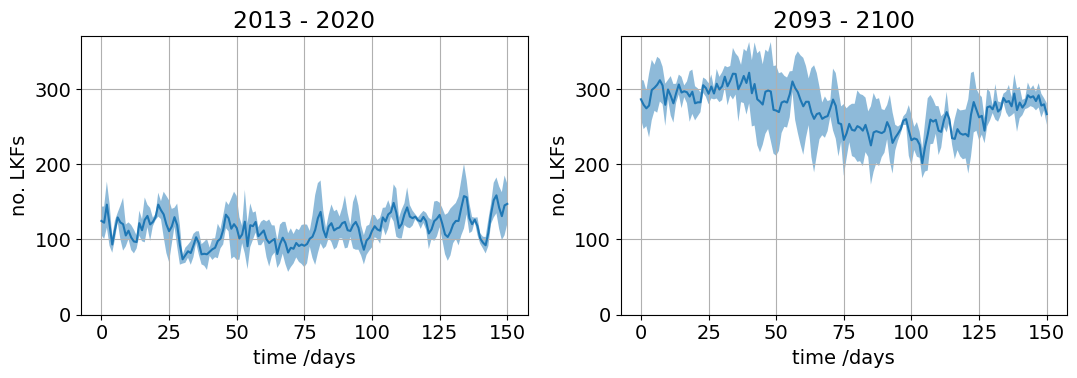

In [23]:
compare('number', 'no. LKFs', 370)

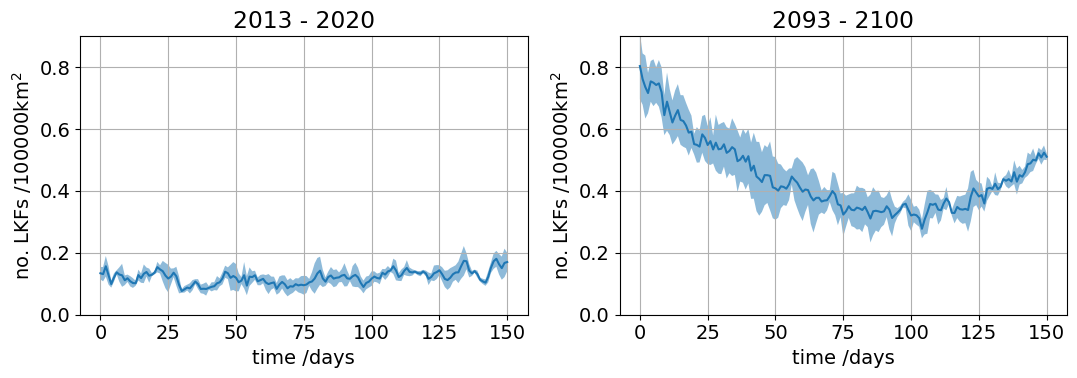

In [24]:
compare('density', 'no. LKFs /100000km$^2$', 0.9)

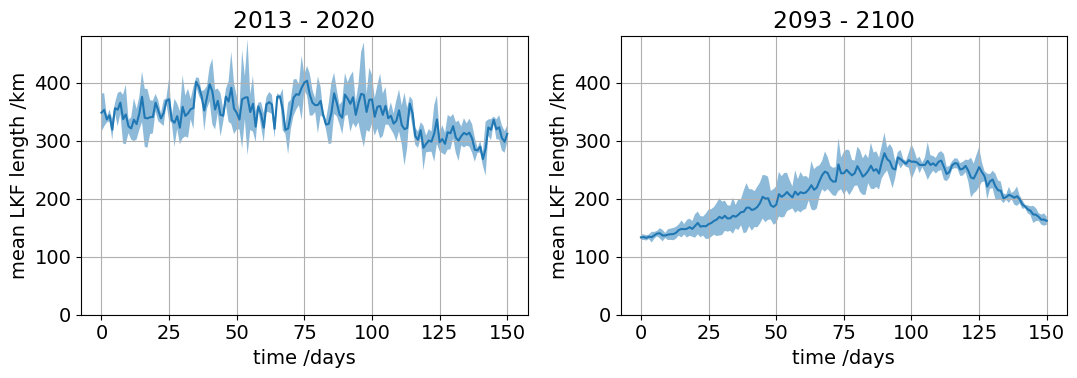

In [25]:
compare('mean length', 'mean LKF length /km', 480)

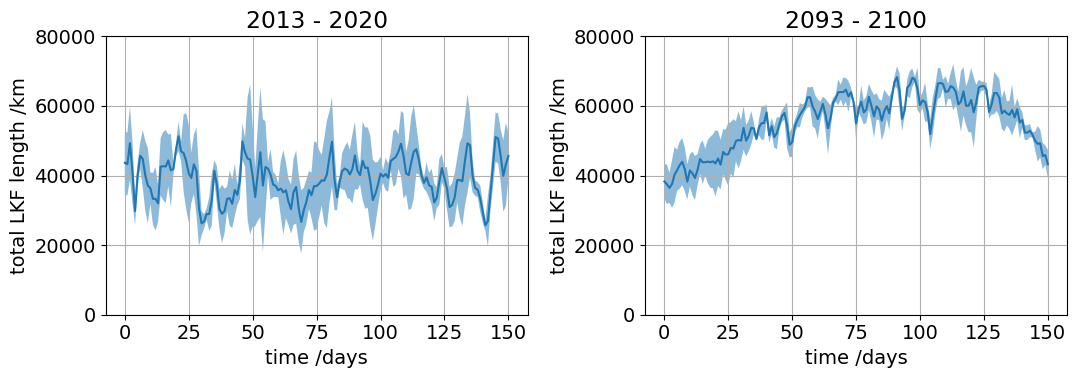

In [26]:
compare('total length', 'total LKF length /km', 80000)

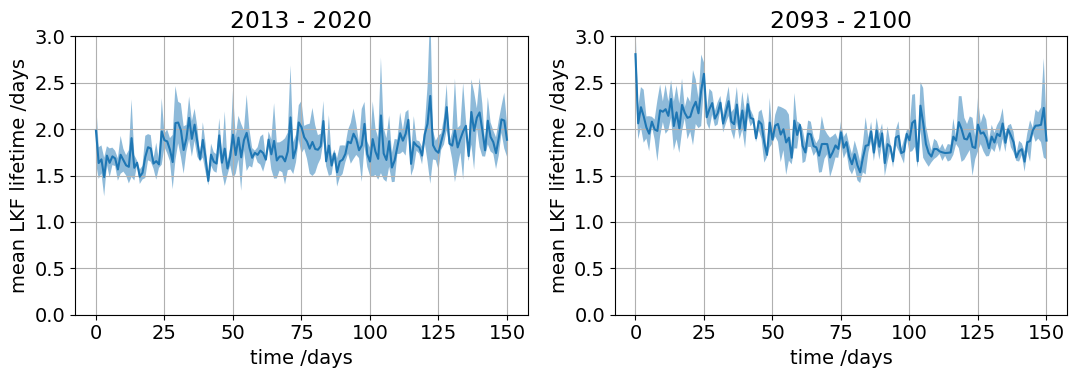

In [27]:
compare('mean lifetime', 'mean LKF lifetime /days', 3)

# 